In [1]:
from read_clustering.variant_call import VariantCall
path = 'C:/Users/lalaj/PycharmProjects/untitled3/read_clustering/tests/test_files/native_cbf5_gal.csv'
path = '/Users/andrewbailey/PycharmProjects/read_clustering/tests/test_files/native_cbf5_gal.csv'

native = VariantCall(path)

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


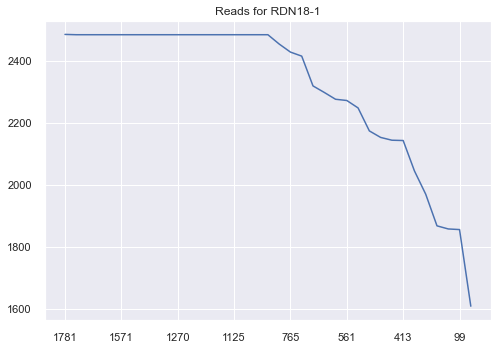

(None, 1609)

In [2]:
native.plot_number_reads_covering_positions('RDN18-1')

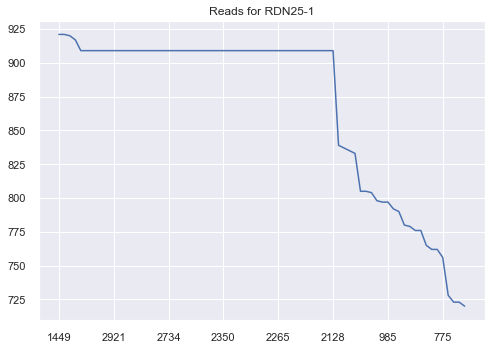

(None, 720)

In [3]:
native.plot_number_reads_covering_positions('RDN25-1')

Now plotting and clustering the datasets. Coordinates are the probabilities. Each point is a read (one same read id) that covers all given positions. 

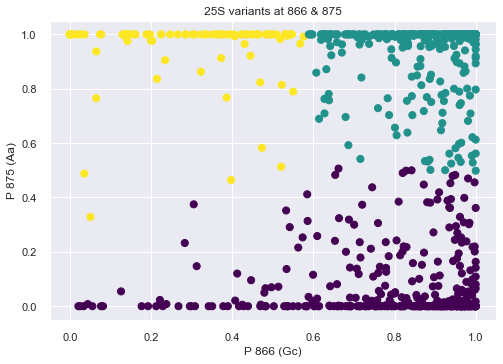

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plot_df = native.get_reads_covering_positions_data([866, 875])
X = plot_df.loc[:, ['P 866', 'P 875']].values 
kmeans = KMeans(n_clusters=3)             
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.title("25S variants at 866 & 875")
plt.xlabel('P 866 (Gc)')
plt.ylabel('P 875 (Aa)')
plt.show()

Now using GaussianMixture to cluster:

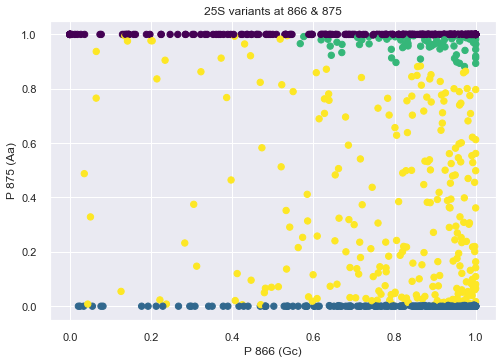

In [5]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)     
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.title("25S variants at 866 & 875")
plt.xlabel('P 866 (Gc)')
plt.ylabel('P 875 (Aa)')
plt.show()

Now using t-SNE to do dimensionality reduction: to visualize a higher-dimension dataset in onle 2 dimensions. 

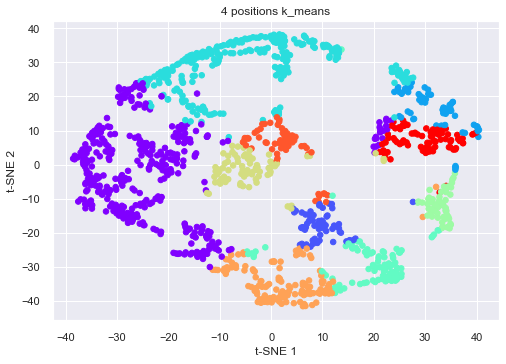

In [6]:
#4 random positions without any clustering
native.plot_tSNE_reads_covering_positions_data([2728, 2734, 2790, 2842], 'k_means', max_number_clusters=10, find_optimal=False)    

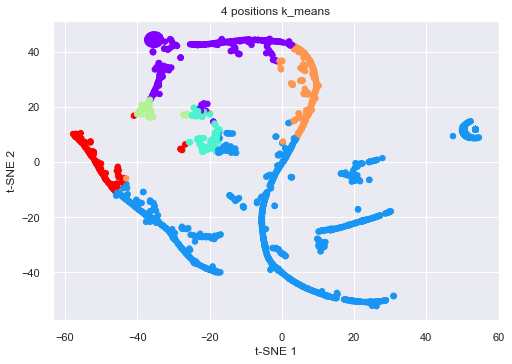

In [7]:
#Positions chosen toward the 3' end of 18S. 
#4 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427], 'k_means', max_number_clusters=6, find_optimal=False) 

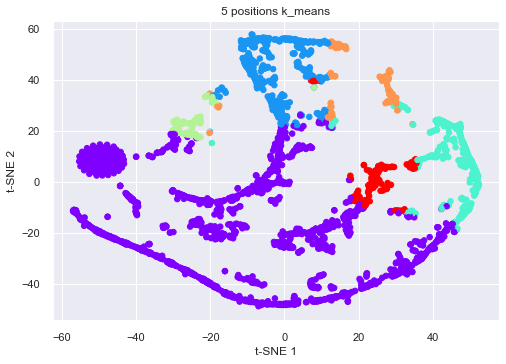

In [8]:
#5 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414], 'k_means', max_number_clusters=6, find_optimal=False)

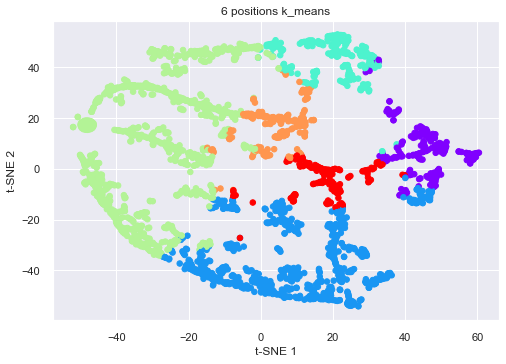

In [9]:
#6 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414, 1289], 'k_means', max_number_clusters=6, find_optimal=False)

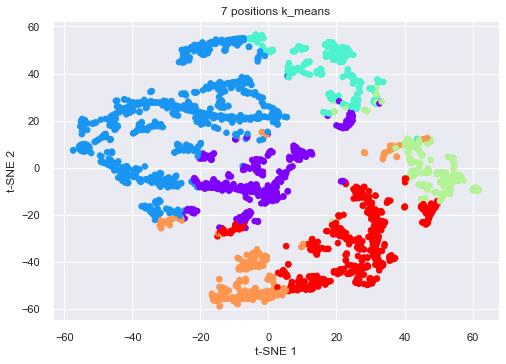

In [10]:
#7 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414, 1289, 1279], 'k_means', max_number_clusters=6, find_optimal=False) 

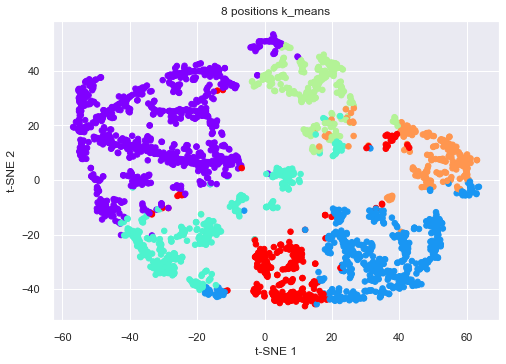

In [11]:
#8 positions
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414, 1289, 1279, 1270], 'k_means', max_number_clusters=6, find_optimal=False)   

The method has also the option to cluster with GaussianMixture (but it shows to be more inaccurate).

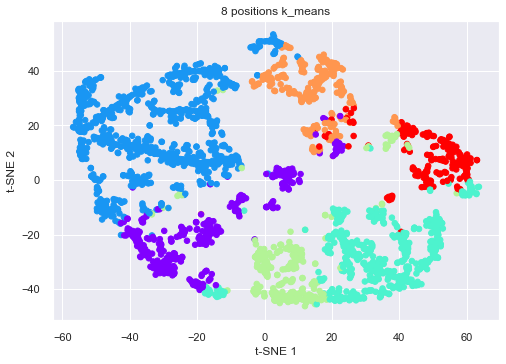

In [12]:
#8 positions with GMM
native.plot_tSNE_reads_covering_positions_data([1638, 1574, 1571, 1427, 1414, 1289, 1279, 1270], 'k_means', max_number_clusters=6, find_optimal=False)     

t-SNE plotting and KMeans clustering for all positions covered by all reads in 18S and 25S:

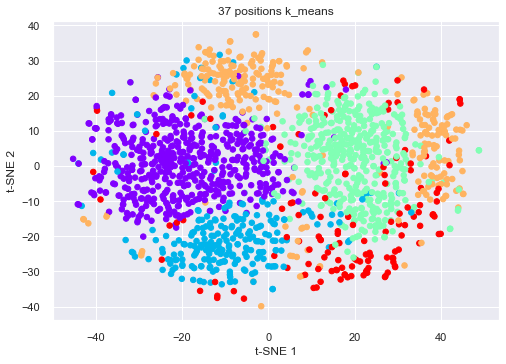

In [13]:
pos18S = native.get_contig_positions('RDN18-1')
native.plot_tSNE_reads_covering_positions_data(pos18S, 'k_means', max_number_clusters=5, find_optimal=False)

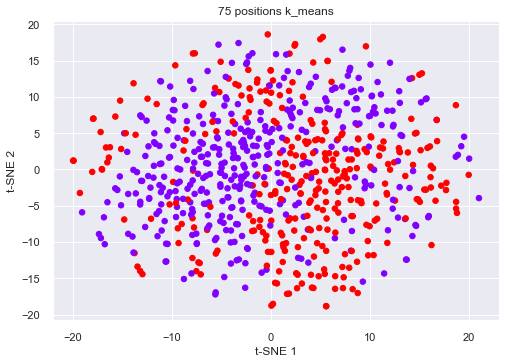

In [14]:
pos25S = native.get_contig_positions('RDN25-1')
native.plot_tSNE_reads_covering_positions_data(pos25S, 'k_means', max_number_clusters=2, find_optimal=False)

PCA plotting and KMeans clustering for all positions covered by all reads in 18S and 25S:

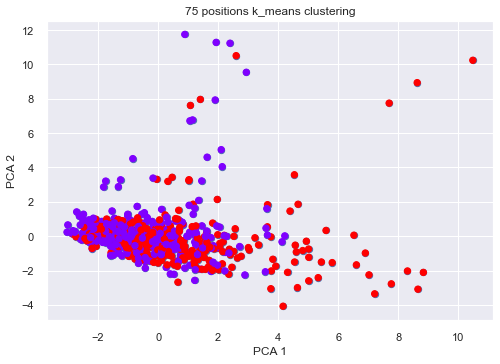

In [15]:
#25S
native.plot_PCA_reads_covering_positions_data(pos25S, 'k_means', max_number_clusters=2, find_optimal=False)

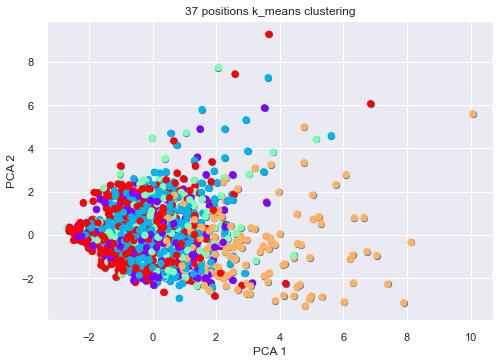

In [16]:
#18S
native.plot_PCA_reads_covering_positions_data(pos18S, 'k_means', max_number_clusters=5, find_optimal=False)